# PAD4 Measurement

This notebook is an example of how to measure impedance on multiple cells in a stack in parallel with the [PAD4 card](https://zahner.de/products-details/addon-cards/pad4).

The main channel is connected to the stack and the two PAD4 channels are each connected to one of the two cells.  
For this example, the cells are each a parallel connection of a capacitor with a resistor and a series resistor.

The impedance spectra are then imported into Python and plotted using [matplotlib](https://matplotlib.org/).


In [1]:
import sys
from thales_remote.connection import ThalesRemoteConnection
from thales_remote.script_wrapper import (
    PotentiostatMode,
    ScanStrategy,
    ScanDirection,
    FileNaming,
    Pad4Mode,
    ThalesRemoteScriptWrapper,
)

from zahner_analysis.file_import.ism_import import IsmImport
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import EngFormatter


# Connect Python to the already launched Thales-Software

In [2]:
if __name__ == "__main__":
    zenniumConnection = ThalesRemoteConnection()
    zenniumConnection.connectToTerm("localhost", "ScriptRemote")

    zahnerZennium = ThalesRemoteScriptWrapper(zenniumConnection)
    zahnerZennium.forceThalesIntoRemoteScript()

    zahnerZennium.calibrateOffsets()

devel version


# Setting the parameters for the measurement

After the connection with Thales, the naming of the files of the measurement results is set.

Measure EIS spectra with a sequential number in the file name that has been specified.
Starting with number 1.

In [3]:
zahnerZennium.setEISNaming(FileNaming.COUNTER)
zahnerZennium.setEISCounter(1)
zahnerZennium.setEISOutputPath(r"C:\THALES\temp\test1")
zahnerZennium.setEISOutputFileName("spectra_cells")

'OK\r'

Setting the parameters for the spectra.

In [4]:
zahnerZennium.setPotentiostatMode(PotentiostatMode.POTMODE_POTENTIOSTATIC)
zahnerZennium.setAmplitude(100e-3)
zahnerZennium.setPotential(0)
zahnerZennium.setLowerFrequencyLimit(0.1)
zahnerZennium.setStartFrequency(1000)
zahnerZennium.setUpperFrequencyLimit(10000)
zahnerZennium.setLowerNumberOfPeriods(2)
zahnerZennium.setLowerStepsPerDecade(5)
zahnerZennium.setUpperNumberOfPeriods(20)
zahnerZennium.setUpperStepsPerDecade(10)
zahnerZennium.setScanDirection(ScanDirection.START_TO_MAX)
zahnerZennium.setScanStrategy(ScanStrategy.SINGLE_SINE)

'OK\r'

# Setting up PAD4

The individual PAD4 channels must be switched on with [setupPad4Channel()](https://doc.zahner.de/thales_remote/script_wrapper.html#thales_remote.script_wrapper.ThalesRemoteScriptWrapper.setupPad4Channel) and finally the general PAD4 must be allowed for impedance measurement with [enablePad4Global()](https://doc.zahner.de/thales_remote/script_wrapper.html#thales_remote.script_wrapper.ThalesRemoteScriptWrapper.enablePad4Global).

By default, the PAD4 channel is set to a voltage channel with 4 V range.

The input voltage range can be set with the parameter *voltageRange* of the method [setupPad4Channel()](https://doc.zahner.de/thales_remote/script_wrapper.html#thales_remote.script_wrapper.ThalesRemoteScriptWrapper.setupPad4Channel). **The input voltage range depends on the used cables and the used PAD4 card. This is only a factor for the software, nothing is switched.**

Also it is possible to measure current with all PAD4 channels if external shunts are used. This can setup with [setupPad4ModeGlobal()](https://doc.zahner.de/thales_remote/script_wrapper.html#thales_remote.script_wrapper.ThalesRemoteScriptWrapper.setupPad4ModeGlobal) for all channels. The external shunt resistor is defined with the parameter *shuntResistor* of the method [setupPad4Channel()](https://doc.zahner.de/thales_remote/script_wrapper.html#thales_remote.script_wrapper.ThalesRemoteScriptWrapper.setupPad4Channel).

In [5]:
zahnerZennium.setupPad4Channel(1, 1, 1, voltageRange=4.0, shuntResistor=10e-3)
zahnerZennium.setupPad4Channel(1, 2, 1, voltageRange=4.0, shuntResistor=10e-3)
zahnerZennium.setupPad4ModeGlobal(Pad4Mode.VOLTAGE)  # or Pad4Mode.CURRENT
zahnerZennium.enablePad4Global()

'OK\r'

# Spectra measurement

After setting the parameters, the measurement is started.  

<div class="alert alert-block alert-info">
<b>Note:</b> If the potentiostat is set to potentiostatic before the impedance measurement and is switched off, the measurement is performed at the open circuit voltage/potential.
</div>

After the measurement the potentiostat is switched off.

In [6]:
zahnerZennium.enablePotentiostat()
zahnerZennium.measureEIS()
zahnerZennium.disablePotentiostat()
zahnerZennium.setAmplitude(0)
zenniumConnection.disconnectFromTerm()

# Importing the ism file

Import the spectrum from the previous measurement.
This was saved under the set path and name with the number expanded.  
The files of the measurement results with PAD4 are numbered consecutively. The lowest number is the main channel of the potentiostat.  
The measurement starts at 1 therefore the following path results: *"C:\THALES\temp\test1\spectra_cells_0001_ser00.ism"*.

In [7]:
ismFileStack = IsmImport(r"C:\THALES\temp\test1\spectra_cells_0001_ser00.ism")
impedanceFrequenciesStack = ismFileStack.getFrequencyArray()
impedanceAbsoluteStack = ismFileStack.getImpedanceArray()
impedancePhaseStack = ismFileStack.getPhaseArray()
impedanceComplexStack = ismFileStack.getComplexImpedanceArray()

ismFileCell1 = IsmImport(r"C:\THALES\temp\test1\spectra_cells_0001_ser01.ism")
impedanceFrequenciesCell1 = ismFileCell1.getFrequencyArray()
impedanceAbsoluteCell1 = ismFileCell1.getImpedanceArray()
impedancePhaseCell1 = ismFileCell1.getPhaseArray()
impedanceComplexCell1 = ismFileCell1.getComplexImpedanceArray()

ismFileCell2 = IsmImport(r"C:\THALES\temp\test1\spectra_cells_0001_ser02.ism")
impedanceFrequenciesCell2 = ismFileCell2.getFrequencyArray()
impedanceAbsoluteCell2 = ismFileCell2.getImpedanceArray()
impedancePhaseCell2 = ismFileCell2.getPhaseArray()
impedanceComplexCell2 = ismFileCell2.getComplexImpedanceArray()

# Displaying the measurement results

The spectra are presented in the Nyquist representation.

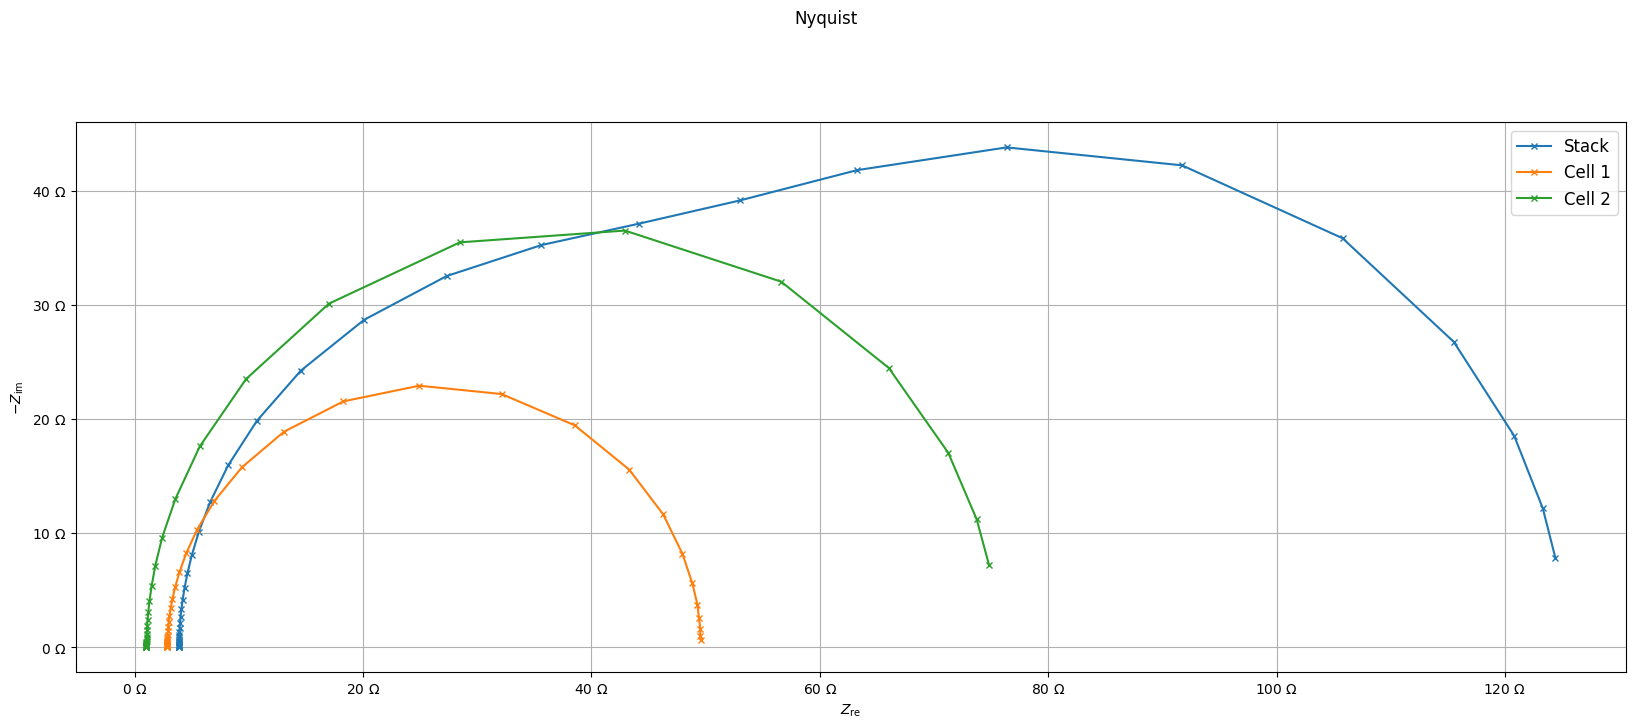

In [8]:
figNyquist, (nyquistAxis) = plt.subplots(1, 1)
figNyquist.suptitle("Nyquist")

nyquistAxis.plot(
    np.real(impedanceComplexStack),
    -np.imag(impedanceComplexStack),
    marker="x",
    markersize=5,
    label="Stack",
)
nyquistAxis.plot(
    np.real(impedanceComplexCell1),
    -np.imag(impedanceComplexCell1),
    marker="x",
    markersize=5,
    label="Cell 1",
)
nyquistAxis.plot(
    np.real(impedanceComplexCell2),
    -np.imag(impedanceComplexCell2),
    marker="x",
    markersize=5,
    label="Cell 2",
)

nyquistAxis.grid(which="both")
nyquistAxis.set_aspect("equal")
nyquistAxis.xaxis.set_major_formatter(EngFormatter(unit="$\Omega$"))
nyquistAxis.yaxis.set_major_formatter(EngFormatter(unit="$\Omega$"))
nyquistAxis.set_xlabel(r"$Z_{\rm re}$")
nyquistAxis.set_ylabel(r"$-Z_{\rm im}$")
nyquistAxis.legend(fontsize="large")
figNyquist.set_size_inches(20, 8)
plt.show()
figNyquist.savefig("nyquist.svg")